In [2]:
%matplotlib inline
from __future__ import print_function, division

import math
import numpy as np

import first
import thinkplot
import thinkstats2

In [5]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

inter, slope = thinkstats2.LeastSquares(ages, weights)
fit_xs, fit_ys = thinkstats2.FitLine(ages, inter, slope)

/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


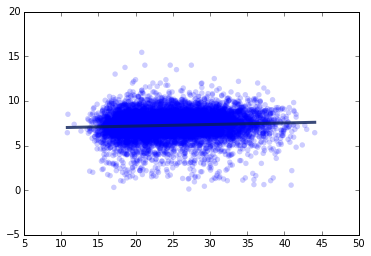

In [6]:
thinkplot.Scatter(ages, weights)
thinkplot.Plot(fit_xs, fit_ys)
thinkplot.Show()

In [7]:
def SamplingDistributions(live, iters=101):
    """Estimates sampling distributions by resampling rows.

    live: DataFrame
    iters: number of times to run simulations

    returns: pair of sequences (inters, slopes)
    """
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = thinkstats2.LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [9]:
def Summarize(estimates, actual=None):
    """Prints standard error and 90% confidence interval.

    estimates: sequence of estimates
    actual: float actual value
    """
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [10]:
inters, slopes = SamplingDistributions(live)

In [12]:
Summarize(inters)

mean, SE, CI 6.82515624551 0.067539983475 (6.7263898699440032, 6.9402087775962231)


In [13]:
Summarize(slopes)

mean, SE, CI 0.0175760127125 0.0027386846078 (0.012977429207479583, 0.021492935452254554)


In [14]:
def PlotConfidenceIntervals(xs, inters, slopes, 
                            res=None, percent=90, **options):
    """Plots the 90% confidence intervals for weights based on ages.

    xs: sequence
    inters: estimated intercepts
    slopes: estimated slopes
    res: residuals
    percent: what percentile range to show
    """
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        if res is not None:
            fys += np.random.permutation(res)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

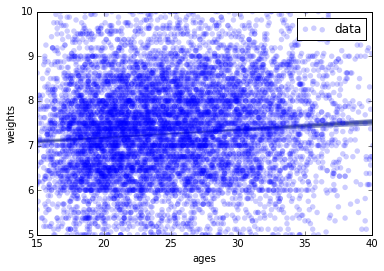

In [26]:
# PlotConfidenceIntervals(ages, inters, slopes, percent=10)
PlotConfidenceIntervals(ages, inters, slopes, percent=50, label='50th Percent')
PlotConfidenceIntervals(ages, inters, slopes, percent=90, label='90th Percent')
thinkplot.Scatter(ages, weights, label='data')
thinkplot.Show(xlabel='ages', ylabel='weights', axis=[15, 40, 5, 10])

In [31]:
class SlopeTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope
    
    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar
        
    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights

In [32]:
ht = SlopeTest((live.agepreg, live.totalwgt_lb))
ht.PValue()

0.0

In [33]:
import brfss
df = brfss.ReadBrfss()

In [40]:
df = df.dropna(subset=['wtkg2', 'htm3'])
df.describe()

,age,sex,wtyrago,finalwt,wtkg2,htm3
count,393518.000000,395832.000000,388137.000000,395832.000000,395832.000000,395832.000000
mean,54.891207,1.612730,79.766921,562.527274,79.044413,168.956188
std,16.742237,0.487127,20.574880,1076.206594,19.547890,10.390752
min,18.000000,1.000000,22.727273,1.695143,20.000000,61.000000
25%,43.000000,1.000000,64.545455,97.241254,64.550000,163.000000
50%,55.000000,2.000000,77.272727,234.914579,77.270000,168.000000
75%,67.000000,2.000000,90.909091,593.585278,90.910000,178.000000
max,99.000000,2.000000,342.272727,60995.111700,300.000000,236.000000


In [41]:
heights = df.htm3
log_weights = np.log(df.wtkg2)
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope)

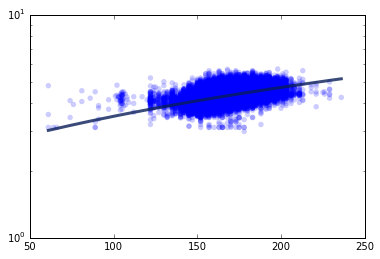

In [43]:
thinkplot.Scatter(heights, log_weights)
thinkplot.Plot(fit_xs, fit_ys)
thinkplot.Show()

In [39]:
fit_xs, fit_ys

(array([ 61.,  61.,  61., ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]))

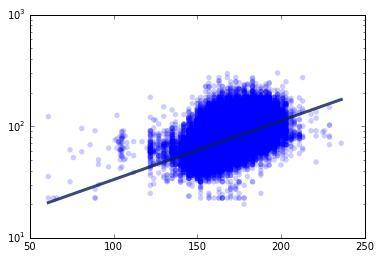

In [44]:
weights = df.wtkg2
thinkplot.Scatter(heights, weights)
thinkplot.Plot(fit_xs, np.exp(fit_ys))
thinkplot.Show(yscale='log')

In [45]:
def SamplingDistributions(live, iters=101):
    """Estimates sampling distributions by resampling rows.

    live: DataFrame
    iters: number of times to run simulations

    returns: pair of sequences (inters, slopes)
    """
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(live)
        heights = sample.htm3
        log_weights = np.log(sample.wtkg2)
        estimates = thinkstats2.LeastSquares(heights, log_weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [46]:
i, s = SamplingDistributions(df)

In [47]:
def PlotExpConfidenceIntervals(xs, inters, slopes, 
                            res=None, percent=90, **options):
    """Plots the 90% confidence intervals for weights based on ages.

    xs: sequence
    inters: estimated intercepts
    slopes: estimated slopes
    res: residuals
    percent: what percentile range to show
    """
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        if res is not None:
            fys += np.random.permutation(res)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, np.exp(low), np.exp(high), **options)

In [48]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
r_2 = thinkstats2.CoefDetermination(log_weights, res)
r_2

0.28273494311901137

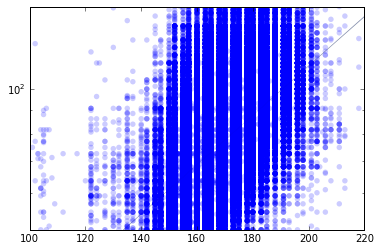

In [50]:
PlotExpConfidenceIntervals(heights, i, s)
thinkplot.Scatter(heights, weights)
thinkplot.Show(yscale='log', axis=[100, 220, 50, 150])

In [52]:
estimates = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates)

mean, SE, CI 168.95427689 0.0147272666203 (168.9313572424665, 168.97788455708482)


In [55]:
estimates = [thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates)

mean, SE, CI 170.494223812 0.0174021186728 (170.46406556316822, 170.5239167121405)


{'xscale': 'linear', 'yscale': 'linear'}

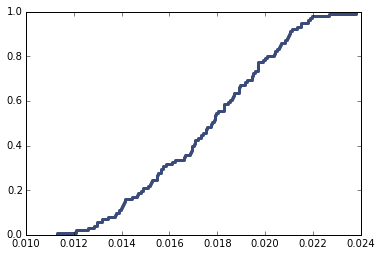

In [56]:
s_cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(s_cdf)

In [54]:
def ResampleRowsWeighted(df, attr='finalwgt'):
    """Resamples a DataFrame using probabilities proportional to finalwgt.

    df: DataFrame
    attr: string column name to use as weights

    returns: DataFrame
    """
    weights = df[attr]
    cdf = thinkstats2.Pmf(weights).MakeCdf()
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample